# Lambda School Data Science - A First Look at Data



## Lecture - let's explore Python DS libraries and examples!

The Python Data Science ecosystem is huge. You've seen some of the big pieces - pandas, scikit-learn, matplotlib. What parts do you want to see more of?

In [1]:
# TODO - we'll be doing this live, taking requests
# and reproducing what it is to look up and learn things

1+1

2

## Assignment - now it's your turn

Pick at least one Python DS library, and using documentation/examples reproduce in this notebook something cool. It's OK if you don't fully understand it or get it 100% working, but do put in effort and look things up.

[(0.02427472694984334, 0.0022998327415702045), (0.0022998327415702045, 0.0002227976688095402), (0.0002227976688095402, 2.1628590428269254e-05), (2.1628590428269254e-05, 2.1000670853516406e-06), (2.1000670853516406e-06, 2.0391379205951542e-07), (2.0391379205951542e-07, 1.9799802456753853e-08), (1.9799802456753853e-08, 1.922539155128252e-09), (1.922539155128252e-09, 1.8667645180559052e-10), (1.8667645180559052e-10, 1.8126079578801485e-11), (1.8126079578801485e-11, 1.7600225297542475e-12), (1.7600225297542475e-12, 1.7089626534112675e-13), (1.7089626534112675e-13, 1.6593840711612476e-14), (1.6593840711612476e-14, 1.6112438092943212e-15), (1.6112438092943212e-15, 1.5645001408098013e-16), (1.5645001408098013e-16, 1.519112549245975e-17), (1.519112549245975e-17, 1.4750416935610597e-18), (1.4750416935610597e-18, 1.4322493740331687e-19), (1.4322493740331687e-19, 1.3906984991495686e-20), (1.3906984991495686e-20, 1.3503530534565088e-21), (1.3503530534565088e-21, 1.3111780663417583e-22), (1.3111780

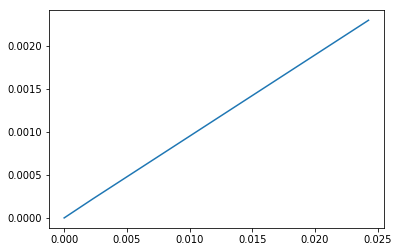

In [2]:
import matplotlib.pyplot as plt
import random
import numpy as np

a=random.uniform(0,4)
x =0.5

y=a*x*(1-x) 
points_plot=[]


for i in range (1000):
  x,y=y,a*y*(1-y)
  z=(x,y)
  points_plot.append(z)
  
print(points_plot)  
plt.plot(*zip(*points_plot));

#logistic function biology , it's a choatic representation of a population of an organism
#https://www.quora.com/What-is-logistic-growth-in-biology


### Assignment questions

After you've worked on some code, answer the following questions in this text block:

1. Describe in a paragraph of text what you did and why, as if you were writing an email to somebody interested but nontechnical.

I plotted a graph which randomly generates a population represing living organism. I got the equation from my little brother who is now studying sciences and mathematics in his final year of highschool.

2.  What was the most challenging part of what you did?

The plot is interesting because unlike normal cartesian plots that plot each dependent variable for every independent variable this graph plots the dependent variable for every independent variable and then reuses the dependent variable as the next independent variable. [(x,y), (y,z), (z,a)...] 

I did not manage to plot the different random graphs generated in this manner simultaneously on 1 graph, but that would have expressed the chaotic nature of such equations.

3.  What was the most interesting thing you learned?

The power of the libraries.

4.  What area would you like to explore with more time?

I would like to use tensorflow sometime. I have seen it being used in youtube videos to reate interesting things.

## Stretch goals and resources

Following are *optional* things for you to take a look at. Focus on the above assignment first, and make sure to commit and push your changes to GitHub (and since this is the first assignment of the sprint, open a PR as well).

- [pandas documentation](https://pandas.pydata.org/pandas-docs/stable/)
- [scikit-learn documentation](http://scikit-learn.org/stable/documentation.html)
- [matplotlib documentation](https://matplotlib.org/contents.html)
- [Awesome Data Science](https://github.com/bulutyazilim/awesome-datascience) - a list of many types of DS resources

Stretch goals:

- Find and read blogs, walkthroughs, and other examples of people working through cool things with data science - and share with your classmates!
- Write a blog post (Medium is a popular place to publish) introducing yourself as somebody learning data science, and talking about what you've learned already and what you're excited to learn more about.